In [39]:
from fractions import Fraction
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
#from numpy import det
import math
# auto reload modules
#print(Decimal(1) / Decimal(7))
from scipy.interpolate import griddata
import scipy
%run define.ipynb


In [27]:
g = 9.81
cp =1004
eps = 0.622
relhum = .8
e0 = 611.2
L = 2.5e6
psfc = 10e4
a = 17.67; 
b = 243.5
Re = 6.37e6;                 # [m] earth's radius
rho = 1e3; 
jmx=101; #101
delx = 2.0/jmx;
x = np.arange(-1.0+delx/2,1.0,delx, dtype=np.longfloat)

In [65]:
def partial_MEBM(D_input, jmx):
    CMIP5 = io.loadmat('PI_LGM_annual_AHT_TS.mat')
    LGM_deg = CMIP5['lat']
    
    LGM_x = np.sin(LGM_deg/180*np.pi).flatten()
    jmx=101; #101
    delx = 2.0/jmx;
    x = np.arange(-1.0+delx/2,1.0,delx, dtype=np.longfloat)

    #D = D_full_list[1]
    D = np.ones(102)*D_input
    Dhlf = np.ones(101)*D_input
    #Dhlf = (D[:-1]+D[1:])/2

    LGM_AHT = griddata(LGM_x,np.nanmean(CMIP5['LGM_AHT'], axis=0),x, method='linear') *1e15
    LGM_AHT_dry = griddata(LGM_x,np.nanmean(CMIP5['LGM_AHT_dry'], axis=0),x, method='linear')*1e15
    LGM_AHT_moist = griddata(LGM_x,np.nanmean(CMIP5['LGM_AHT_moist'], axis=0),x, method='linear')*1e15
    LGM_TS = griddata(LGM_x,np.nanmean(CMIP5['LGM_TS'], axis=0),x, method='linear')
    LGM_T925 = griddata(LGM_x,np.nanmean(CMIP5['LGM_T925'], axis=0),x, method='linear')
    LGM_OHT = griddata(LGM_x,np.nanmean(CMIP5['LGM_OHT'], axis=0),x, method='linear') *1e15
    LGM_Q = griddata(LGM_x,np.nanmean(CMIP5['LGM_Q925'], axis=0),x, method='linear')
    LGM_E = griddata(LGM_x,np.nanmean(CMIP5['LGM_E'], axis=0),x, method='linear')/(L*rho)*np.pi*1e7
    LGM_P = griddata(LGM_x,np.nanmean(CMIP5['LGM_P'], axis=0),x, method='linear')/(L*rho)*np.pi*1e7
    LGM_T = (LGM_TS+LGM_T925)/2
    LGM_E_m_P = LGM_E - LGM_P
    LGM_divF_moist = Div(x,LGM_AHT_moist)
    LGM_deg = np.array(CMIP5['lat']).flatten()
    LGM_h = LGM_Q * 2.5e6 + LGM_T * 1004
    LGM_h_mean = np.mean(LGM_h)
    LGM_T_mean = np.mean(LGM_T)
    LGM_Q_mean = np.mean(LGM_Q)

    # dhdx = -LGM_AHT*9.8/(Dhlf*4045647.91)/(2*np.pi*1e5*(1-x**2))
    dhdx = LGM_AHT/(-2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x)))

    h = np.zeros(len(x))
    h[1:] += scipy.integrate.cumtrapz(dhdx,x)
    F = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h,x);
    h_mean = np.mean(h)
    h_mean_diff = LGM_h_mean - np.mean(h)
    h = h + h_mean_diff

    def H_to_T(h, H_module_list, T_list): # h is a single value (float), and H_module_list is a list
            if len(h) == 0:
                diff_list = H_module_list - h
                index = np.where(np.abs(diff_list) ==(np.min(np.abs(diff_list))))[0][0]
                result = round(T_list[index],5)
            else:
                result_list = []
                for i in h:
                    diff_list = H_module_list - i
                    result_list.append(round(T_list[np.where(np.abs(diff_list) ==(np.min(np.abs(diff_list))))[0][0]],8))
                    result = result_list
            return np.array(result)
    T_list = np.arange(-80,40.00001,.00001)
    q = eps*relhum/psfc*e0*np.exp(a*(T_list)/(b+(T_list)))
    H_module_list = (T_list+273.15) * cp + L * q
    T = T_by_h_MEBM = H_to_T(h, H_module_list, T_list)

    wt = 1-norm.pdf(x, 0, np.sin(15*2*np.pi/360))/norm.pdf(0, 0, np.sin(15*2*np.pi/360))
    F = LGM_AHT;  # [W] control climate flux 
    q = eps*relhum/psfc*e0*np.exp(a*(T)/(b+(T)))
    F_lh = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q,x);# [W] control latent heat flux
    F_hc = (1-wt)*F; # [W] Hadley Cell Flux
    heq = h[50]; #value at equator WARNING will have to change if change grid ; # [J kg-1] moist static energy at the surface
    V = F_hc/(heq*1.06-h);   # [kg s-1] Diagnosed mass transport in Hadley Cell (Nick's way)
    F_LH = -L*V*q + wt*F_lh;  # [W] latent heat (Hadley plus eddy)
    F_LH_eddy = wt*F_lh; # eddy latent heat fluxes including weighting function."""
    divF_LH = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH,x); # [W m-2] divergence of latent heat flux
    E_m_P = divF_LH/(L*rho)*np.pi*1e7;  
    return T, divF_LH, F, LGM_T-273.15, LGM_divF_moist, LGM_AHT

In [66]:
T, divF_LH, F, LGM_T, LGM_divF_moist, LGM_AHT = partial_MEBM(0.28, 101)

<ipython-input-65-88a5818c6d2f>:19: RuntimeWarning: Mean of empty slice
  LGM_T925 = griddata(LGM_x,np.nanmean(CMIP5['LGM_T925'], axis=0),x, method='linear')
<ipython-input-65-88a5818c6d2f>:21: RuntimeWarning: Mean of empty slice
  LGM_Q = griddata(LGM_x,np.nanmean(CMIP5['LGM_Q925'], axis=0),x, method='linear')


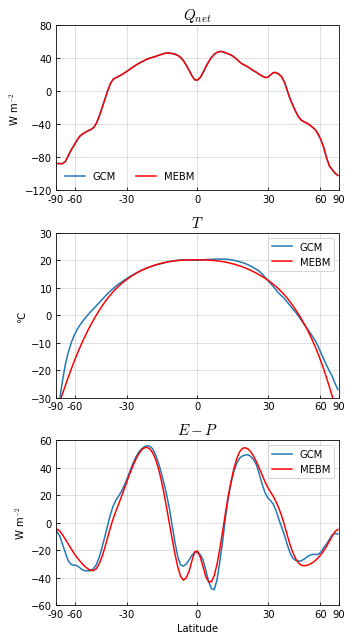

In [67]:
# create the figure and subplots
plt.ioff()
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(5, 9))
plt.rcParams['mathtext.fontset'] = 'cm'

# create each subplot
axis[0].plot(x, Div(x,LGM_AHT), label = r'GCM')
axis[0].plot(x, Div(x,LGM_AHT), label = r"MEBM", color = 'red')

axis[0].set_title(r"$Q_{net}$", fontsize = 15)
axis[0].set_ylim(-120,80)
axis[0].set_xlim(-1,1)
axis[0].legend(ncol=3,frameon=False, loc='lower left')
axis[0].set_ylabel(r"W m$^{-2}$")
axis[0].set_yticks([-120,-80,-40,0,40,80])

#axis[0].grid(alpha = 0.5)

axis[1].plot(x, LGM_T, label = 'GCM')
axis[1].plot(x, T, label = 'MEBM', color = 'red')
axis[1].set_ylim(-30,30)
axis[1].set_title(r"$T$", fontsize = 15)
axis[1].set_ylabel(r"℃")
#axis[1].set_yticks([-20,-10,0,10,20])
axis[1].legend()

axis[2].plot(x, LGM_divF_moist, label = 'GCM')
axis[2].plot(x, divF_LH, label = 'MEBM', color = 'red')
axis[2].set_ylim(-60,60)
axis[2].set_title(r"$E - P$", fontsize = 15)
axis[2].set_ylabel(r"W m$^{-2}$")
#axis[2].set_yticks([-40,-20,0,20,40])
axis[2].legend()


# add a main title to the figure
# fig.suptitle('Trigonometric Functions')
# show the figure
for ax in axis:
    # ax.grid(True,  linestyle='dotted', color='lightgrey')
    ax.set_xlim(-1,1)
    ax.set_xticks([-1,-0.866,-0.5,0,0.5,0.866,1])
    ax.set_xticklabels(['-90', '-60','-30','0', '30','60', '90'])
    ax.grid(alpha = 0.5)
    ax.tick_params(axis='both',direction='in')
axis[2].set_xlabel('Latitude')
fig.tight_layout()
fig.savefig('Full_MEBM.png',dpi=300)
plt.show()